# **PROYEK PREDICTIVE ANALYTICS - RED WINE QUALITY PREDICTION** 

## Import Libraries

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC # Contoh model lain
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Understanding

### Load Data

In [2]:
# Data Understanding - Load Data

file_path = './datasets/winequality-red.csv'
try:
    df = pd.read_csv(file_path, sep=';')
    print("Dataset loaded successfully!")
    print("Shape of dataset:", df.shape)
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the file path.")

if 'df' in locals():
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nDataset Info:")
    df.info()

    print("\nDescriptive Statistics:")
    print(df.describe())

    print("\nChecking for missing values:")
    print(df.isnull().sum())
    
    print("\nChecking for duplicate rows:")
    print(df.duplicated().sum())
    
    print("\nUnique values in each column:")
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} unique values")
    print("\nData types of each column:")
    print(df.dtypes)
else:
    print("Dataset could not be loaded. Please check the file path and try again.")

Dataset loaded successfully!
Shape of dataset: (1599, 12)

First 5 rows of the dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

### EDA (Exploratory Data Analysis)

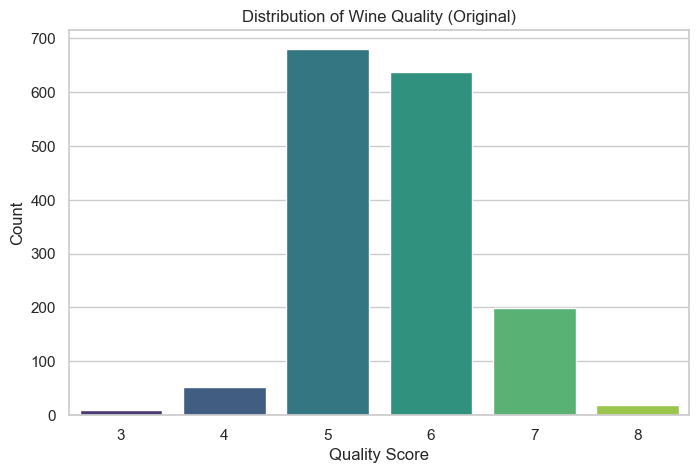


'quality_category' created and original 'quality' column dropped.


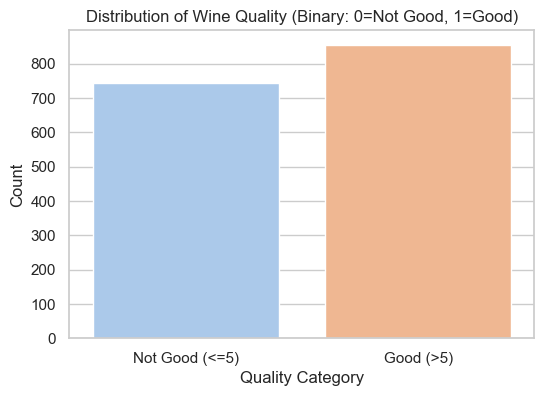


Value counts for 'quality_category':
quality_category
1    855
0    744
Name: count, dtype: int64
Class imbalance ratio (Not Good : Good): 0.87

Missing values after transformation:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
quality_category        0
dtype: int64

Duplicate rows after transformation:
240


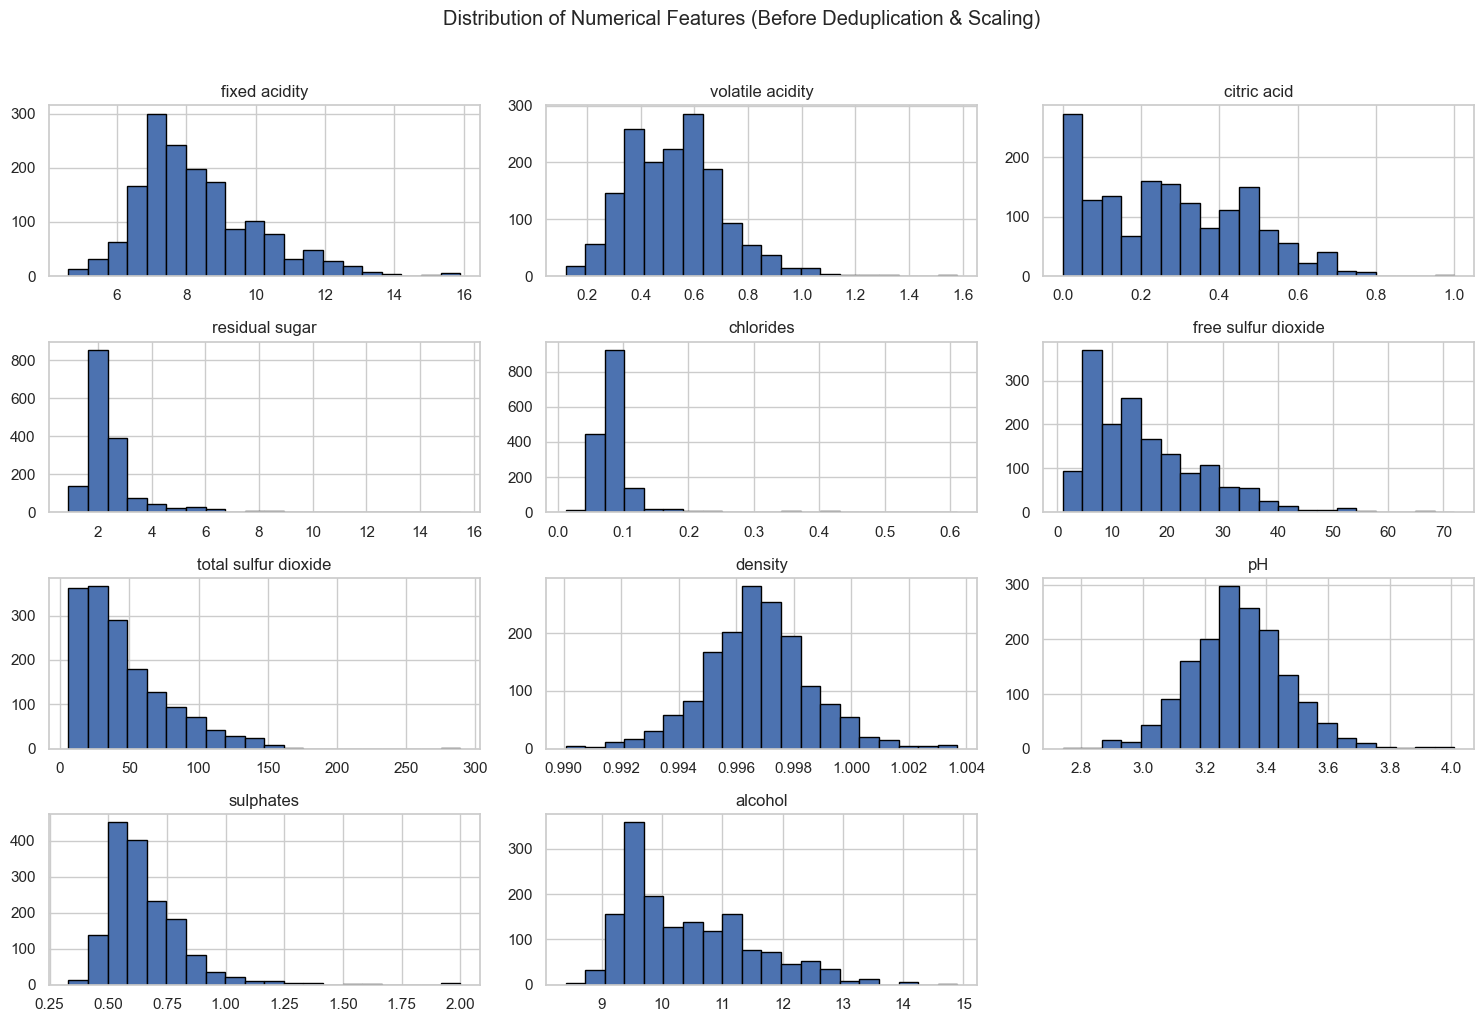

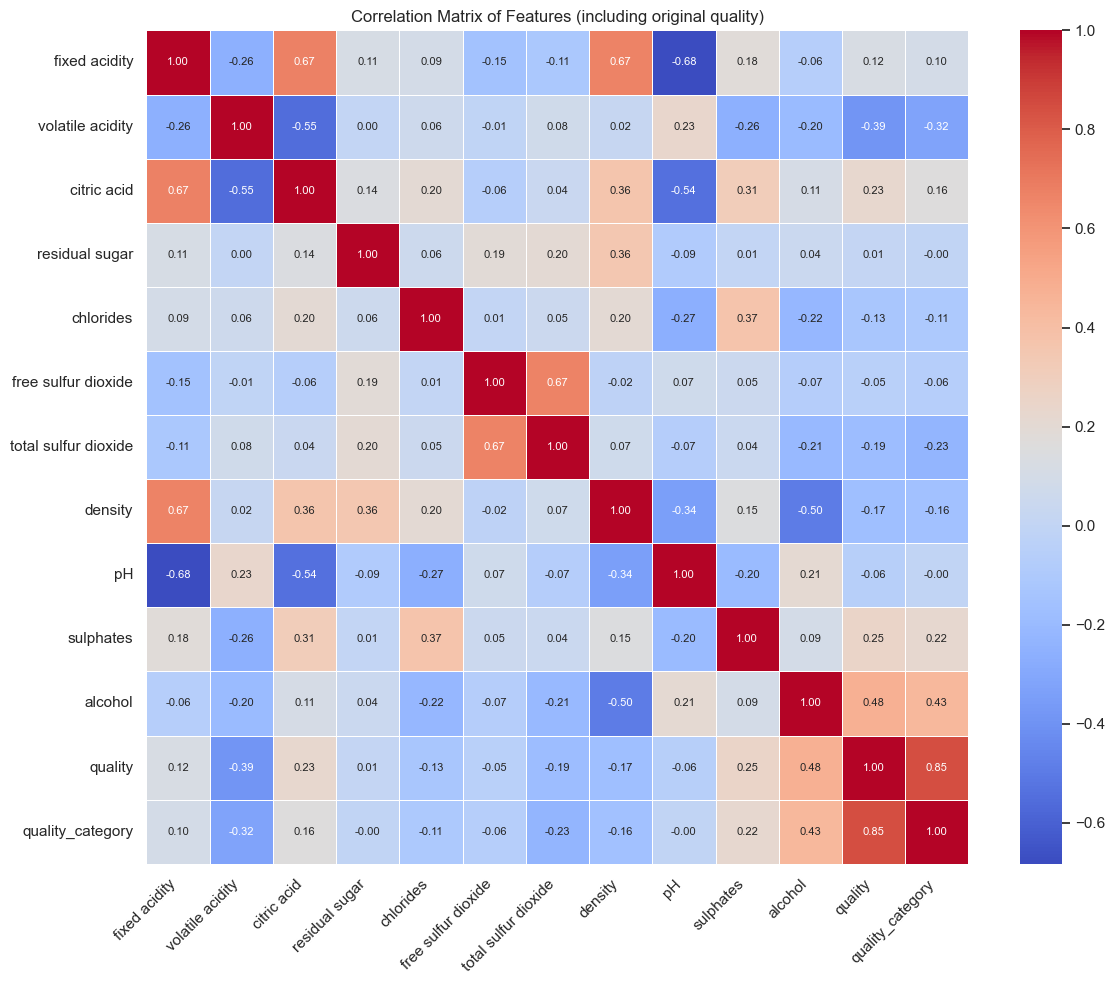

In [3]:
# Data Understanding - EDA (Exploratory Data Analysis)

if 'df' in locals():
    # Distribusi variabel target 'quality' sebelum transformasi
    plt.figure(figsize=(8, 5))
    sns.countplot(x='quality', data=df, palette='viridis')
    plt.title('Distribution of Wine Quality (Original)')
    plt.xlabel('Quality Score')
    plt.ylabel('Count')
    plt.show()

    # Membuat kategori biner untuk 'quality'
    # 'good' (1) if quality > 5, else 'bad' (0)
    df['quality_category'] = df['quality'].apply(lambda x: 1 if x > 5 else 0)
    
    # Simpan df asli sebelum menghapus kolom 'quality' untuk korelasi
    df_for_corr_original = df.copy() 
    
    df_prepared = df.drop('quality', axis=1) # Hapus kolom quality asli
    print("\n'quality_category' created and original 'quality' column dropped.")

    # Distribusi variabel target 'quality_category' setelah transformasi
    plt.figure(figsize=(6, 4))
    sns.countplot(x='quality_category', data=df_prepared, palette='pastel')
    plt.title('Distribution of Wine Quality (Binary: 0=Not Good, 1=Good)')
    plt.xlabel('Quality Category')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Not Good (<=5)', 'Good (>5)'])
    plt.show()
    print("\nValue counts for 'quality_category':")
    class_counts_after_transform = df_prepared['quality_category'].value_counts()
    print(class_counts_after_transform)
    if len(class_counts_after_transform) == 2: # Pastikan ada dua kelas
      print("Class imbalance ratio (Not Good : Good):", f"{class_counts_after_transform.get(0, 0) / class_counts_after_transform.get(1, 1):.2f}" if class_counts_after_transform.get(1,1) != 0 else "N/A")
    
    # Cek nilai yang hilang setelah transformasi
    print("\nMissing values after transformation:")
    print(df.isnull().sum())
    
    # Cek duplikat setelah transformasi
    print("\nDuplicate rows after transformation:")
    print(df.duplicated().sum())
    
    # Visualisasi distribusi fitur kategorikal
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in categorical_features:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, hue='quality_category', data=df, palette='pastel')
        plt.title(f'Distribution of {col} by Quality Category')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Quality Category', loc='upper right', labels=['Not Good (<=5)', 'Good (>5)'])
        plt.show()

    # Visualisasi distribusi fitur numerik (sebelum penghapusan duplikat dan scaling)
    numerical_features = df_prepared.select_dtypes(include=np.number).columns.tolist()
    features_for_hist = [col for col in numerical_features if col not in ['quality_category']]

    if len(features_for_hist) > 0:
        df_prepared[features_for_hist].hist(bins=20, figsize=(15, 10), layout=(-1, 3), edgecolor='black')
        plt.suptitle('Distribution of Numerical Features (Before Deduplication & Scaling)', y=1.02)
        plt.tight_layout()
        plt.show()
    else:
        print("No numerical features available for histogram plotting.")

    # Korelasi antar fitur (menggunakan df asli dengan kolom 'quality')
    plt.figure(figsize=(12, 10))
    correlation_matrix_original = df_for_corr_original.corr()
    sns.heatmap(correlation_matrix_original, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, annot_kws={"size": 8})
    plt.title('Correlation Matrix of Features (including original quality)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Dataset 'df' not loaded. Run previous cells.")

## Data Preparation

Data preparation started.
Number of rows before removing duplicates: 1599
Number of rows after removing duplicates: 1359

Value counts for 'quality_category' after deduplication:
quality_category
1    719
0    640
Name: count, dtype: int64
Class imbalance ratio (Not Good : Good) after deduplication: 0.89

Features (X) and target (y) separated.
Shape of X: (1359, 11)
Shape of y: (1359,)
Data split into training and testing sets.
Shape of X_train: (1087, 11)
Shape of X_test: (272, 11)
Shape of y_train: (1087,)
Shape of y_test: (272,)

Proportion of classes in y_train:
quality_category
1    0.528979
0    0.471021
Name: proportion, dtype: float64

Proportion of classes in y_test:
quality_category
1    0.529412
0    0.470588
Name: proportion, dtype: float64

First 5 rows of scaled training data:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.805013         -0.440050    -0.827412       -0.104942  -0.891400   
1      -0.805013         -0.494360    -1.3

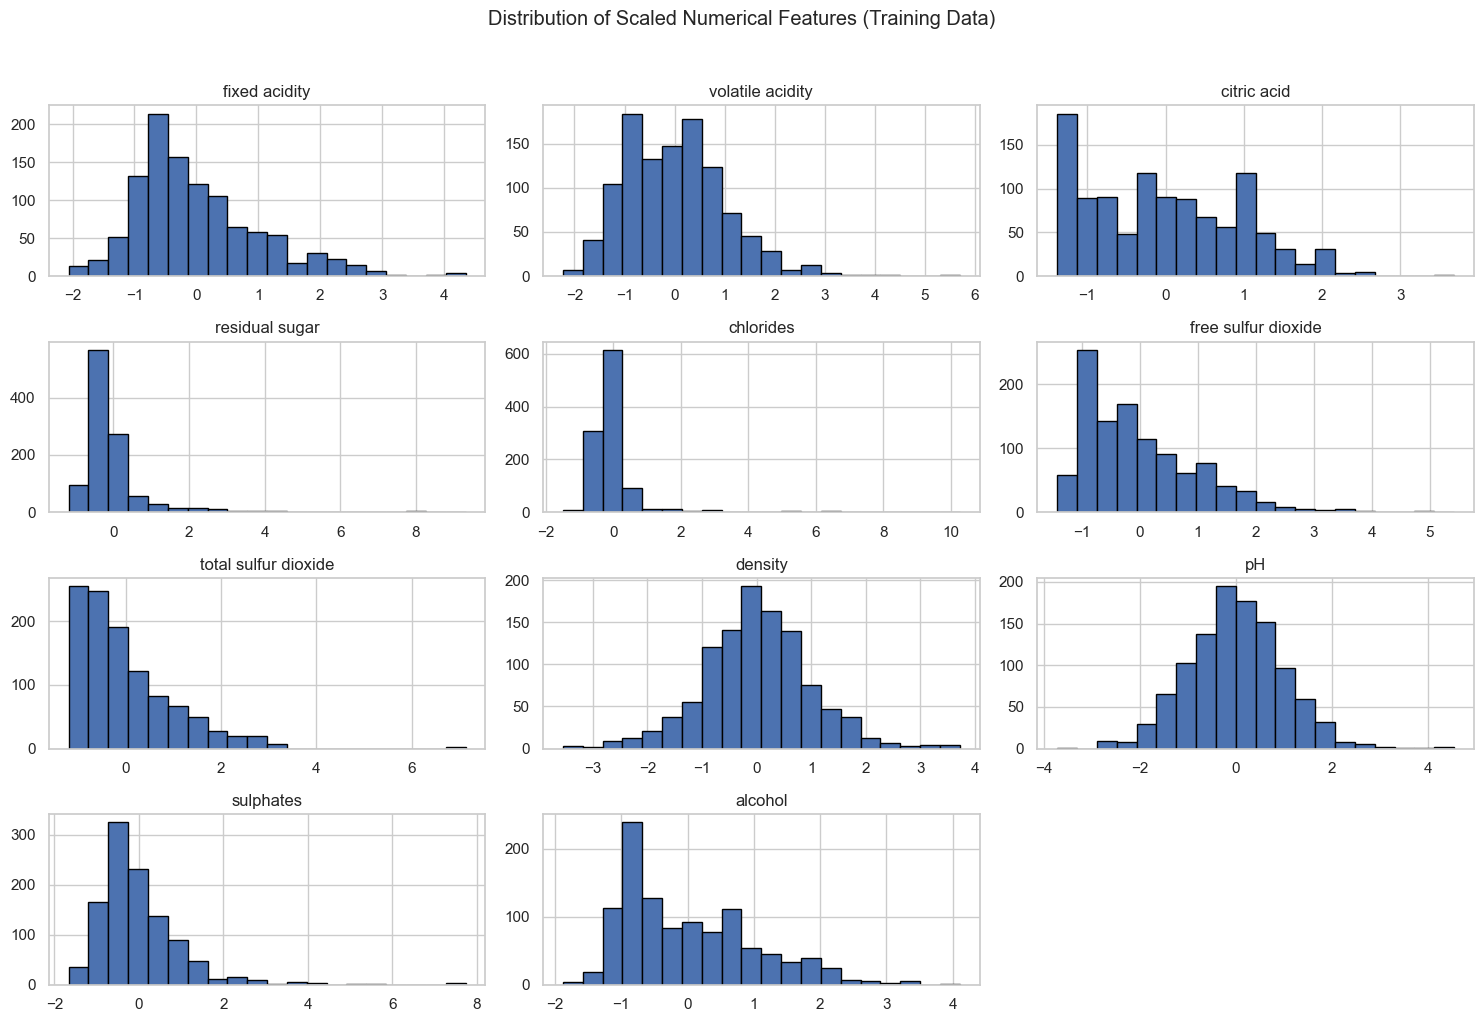


Distribution of features after scaling (Test Data):


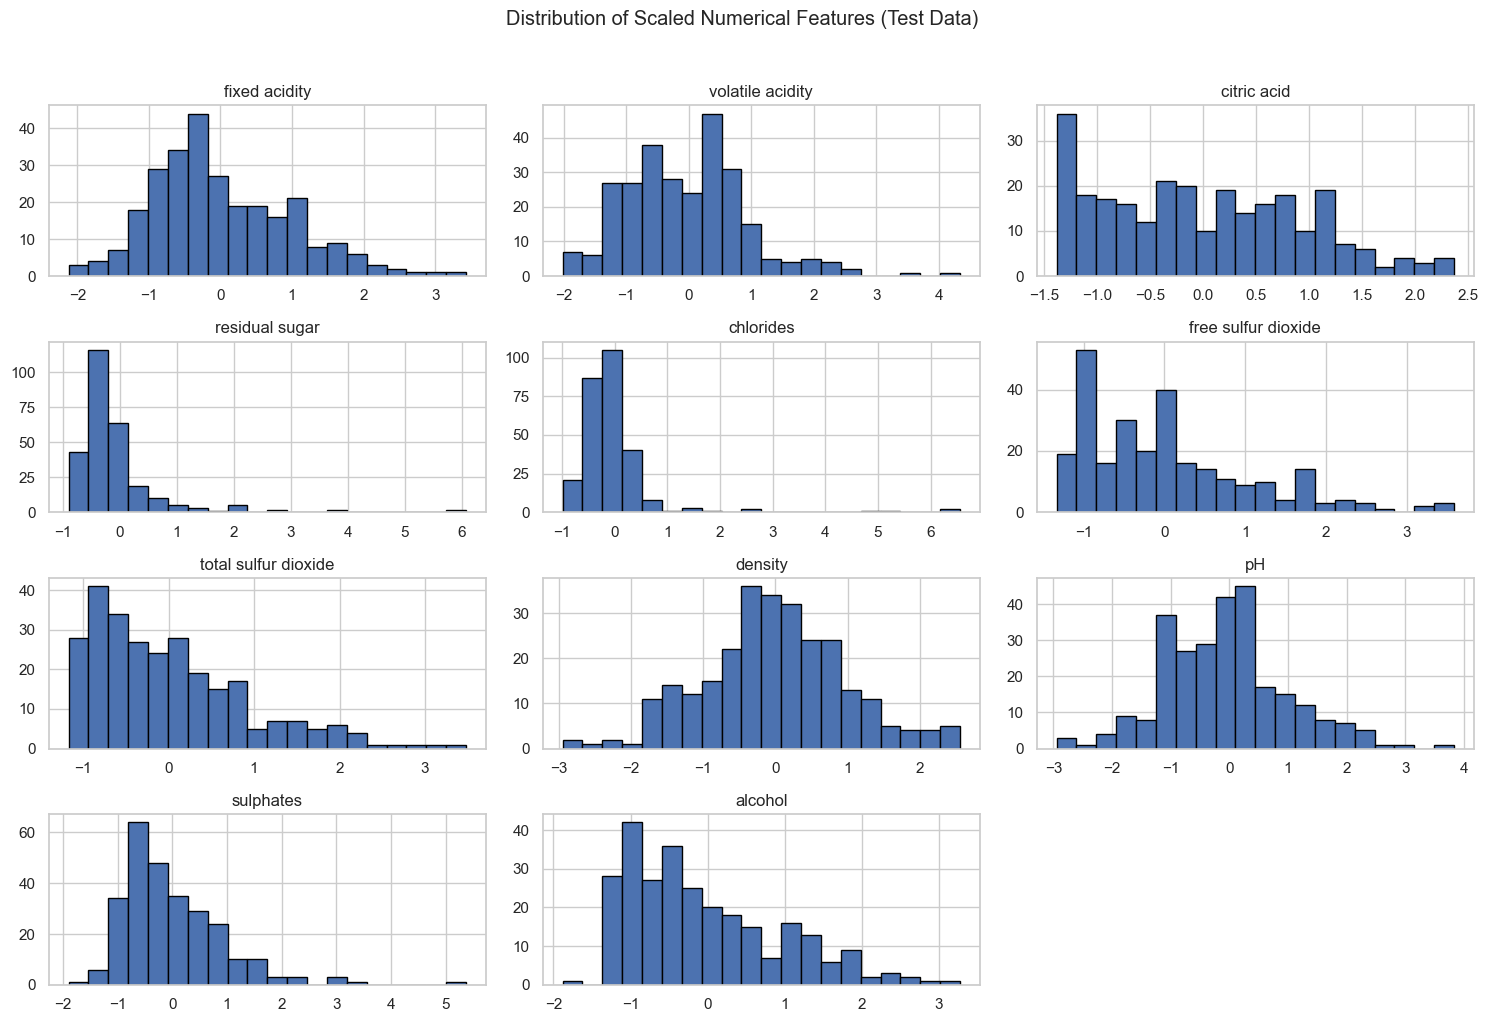


Data preparation complete.


In [4]:
# ============== Data Preparation ==============
if 'df_prepared' in locals():
    print("Data preparation started.")
    print(f"Number of rows before removing duplicates: {len(df_prepared)}")
    df_prepared.drop_duplicates(inplace=True)
    print(f"Number of rows after removing duplicates: {len(df_prepared)}")
    
    # Cek distribusi kelas setelah penghapusan duplikat
    print("\nValue counts for 'quality_category' after deduplication:")
    class_counts_after_dedup = df_prepared['quality_category'].value_counts()
    print(class_counts_after_dedup)
    if len(class_counts_after_dedup) == 2:
      print("Class imbalance ratio (Not Good : Good) after deduplication:", f"{class_counts_after_dedup.get(0, 0) / class_counts_after_dedup.get(1, 1):.2f}" if class_counts_after_dedup.get(1,1) != 0 else "N/A")

    X = df_prepared.drop('quality_category', axis=1)
    y = df_prepared['quality_category']
    print("\nFeatures (X) and target (y) separated.")
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Pemisahan data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Data split into training and testing sets.")
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    print("\nProportion of classes in y_train:")
    print(y_train.value_counts(normalize=True))
    print("\nProportion of classes in y_test:")
    print(y_test.value_counts(normalize=True))


    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # Hanya transform pada data test, tidak fit ulang

    # Mengubah kembali ke DataFrame untuk kemudahan inspeks
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print("\nFirst 5 rows of scaled training data:")
    print(X_train_scaled_df.head())
    print("\nFirst 5 rows of scaled testing data:")
    print(X_test_scaled_df.head())
    
    # Distribusi fitur setelah scaling
    print("\nDistribution of features after scaling (Training Data):")
    X_train_scaled_df.hist(bins=20, figsize=(15, 10), layout=(-1, 3), edgecolor='black')
    plt.suptitle('Distribution of Scaled Numerical Features (Training Data)', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\nDistribution of features after scaling (Test Data):")
    X_test_scaled_df.hist(bins=20, figsize=(15, 10), layout=(-1, 3), edgecolor='black')
    plt.suptitle('Distribution of Scaled Numerical Features (Test Data)', y=1.02)
    plt.tight_layout()
    plt.show()

    print("\nData preparation complete.")
else:
    print("Variable 'df_prepared' not found. Run previous cells.")

## Modeling

### Logistic Regression (Baseline)

Logistic Regression Model Trained.
--- Evaluation on Training Data (Logistic Regression) ---
Accuracy: 0.7433
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       512
           1       0.77      0.74      0.75       575

    accuracy                           0.74      1087
   macro avg       0.74      0.74      0.74      1087
weighted avg       0.74      0.74      0.74      1087


--- Evaluation on Test Data (Logistic Regression) ---
Accuracy: 0.7353
Precision (weighted): 0.7364
Recall (weighted): 0.7353
F1-score (weighted): 0.7355

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.71      0.74      0.73       128
           1       0.76      0.73      0.74       144

    accuracy                           0.74       272
   macro avg       0.73      0.74      0.73       272
weighted avg       0.74      0.74      0.74       272


Confusion Matrix (Test Data):
 [[ 95  33]
 

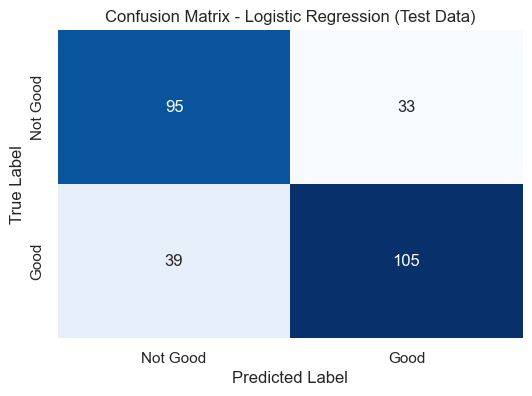

In [5]:
# ============== Modeling - Logistic Regression (Baseline) ==============

if 'X_train_scaled' in locals():
    log_reg = LogisticRegression(random_state=42, solver='liblinear') # liblinear baik untuk dataset kecil
    log_reg.fit(X_train_scaled, y_train)

    y_pred_log_reg_train = log_reg.predict(X_train_scaled)
    y_pred_log_reg_test = log_reg.predict(X_test_scaled)

    print("Logistic Regression Model Trained.")
    print("--- Evaluation on Training Data (Logistic Regression) ---")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_log_reg_train):.4f}")
    print(classification_report(y_train, y_pred_log_reg_train))


    print("\n--- Evaluation on Test Data (Logistic Regression) ---")
    log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg_test)
    log_reg_precision = precision_score(y_test, y_pred_log_reg_test, average='weighted') # or 'binary' if positive_label is 1
    log_reg_recall = recall_score(y_test, y_pred_log_reg_test, average='weighted')
    log_reg_f1 = f1_score(y_test, y_pred_log_reg_test, average='weighted')

    print(f"Accuracy: {log_reg_accuracy:.4f}")
    print(f"Precision (weighted): {log_reg_precision:.4f}")
    print(f"Recall (weighted): {log_reg_recall:.4f}")
    print(f"F1-score (weighted): {log_reg_f1:.4f}")
    print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_log_reg_test))
    print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred_log_reg_test))
    
    cm_log_reg = confusion_matrix(y_test, y_pred_log_reg_test)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Good', 'Good'], yticklabels=['Not Good', 'Good'])
    plt.title('Confusion Matrix - Logistic Regression (Test Data)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

else:
    print("Scaled training data not found. Run previous cells.")

### Random Forest Classifier (Default Parameters)

Random Forest (Default) Model Trained.
--- Evaluation on Training Data (Random Forest Default) ---
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       512
           1       1.00      1.00      1.00       575

    accuracy                           1.00      1087
   macro avg       1.00      1.00      1.00      1087
weighted avg       1.00      1.00      1.00      1087


--- Evaluation on Test Data (Random Forest Default) ---
Accuracy: 0.7684
Precision (weighted): 0.7705
Recall (weighted): 0.7684
F1-score (weighted): 0.7686

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.74      0.79      0.76       128
           1       0.80      0.75      0.77       144

    accuracy                           0.77       272
   macro avg       0.77      0.77      0.77       272
weighted avg       0.77      0.77      0.77       272


Confusion Matrix (Test Data):
 [[10

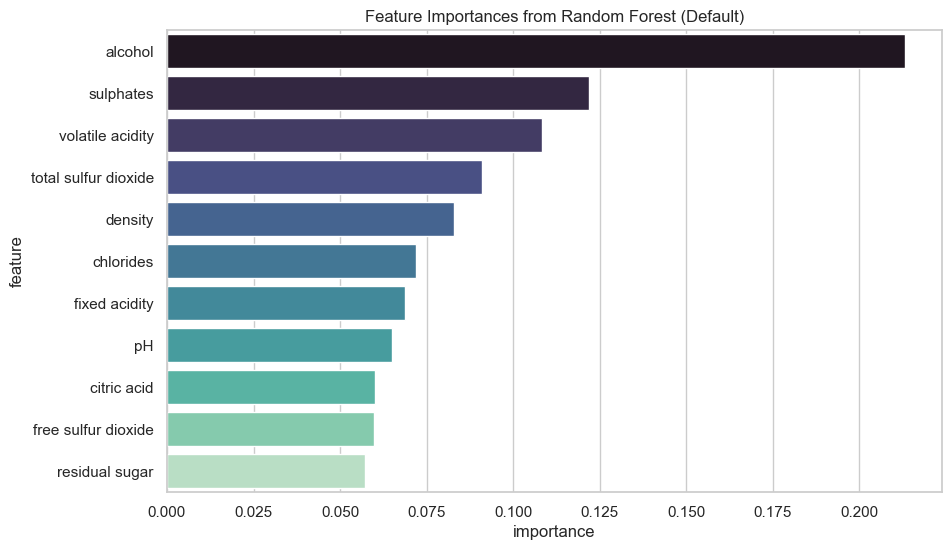


Top 5 Feature Importances:
                 feature  importance
10               alcohol    0.213198
9              sulphates    0.121831
1       volatile acidity    0.108305
6   total sulfur dioxide    0.091078
7                density    0.082844


In [6]:
# ============== Modeling - Random Forest Classifier (Default Parameters) ==============

if 'X_train_scaled' in locals():
    rf_clf_default = RandomForestClassifier(random_state=42)
    rf_clf_default.fit(X_train_scaled, y_train)

    y_pred_rf_default_train = rf_clf_default.predict(X_train_scaled)
    y_pred_rf_default_test = rf_clf_default.predict(X_test_scaled)

    print("Random Forest (Default) Model Trained.")
    print("--- Evaluation on Training Data (Random Forest Default) ---")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_rf_default_train):.4f}")
    print(classification_report(y_train, y_pred_rf_default_train))


    print("\n--- Evaluation on Test Data (Random Forest Default) ---")
    rf_default_accuracy = accuracy_score(y_test, y_pred_rf_default_test)
    rf_default_precision = precision_score(y_test, y_pred_rf_default_test, average='weighted')
    rf_default_recall = recall_score(y_test, y_pred_rf_default_test, average='weighted')
    rf_default_f1 = f1_score(y_test, y_pred_rf_default_test, average='weighted')

    print(f"Accuracy: {rf_default_accuracy:.4f}")
    print(f"Precision (weighted): {rf_default_precision:.4f}")
    print(f"Recall (weighted): {rf_default_recall:.4f}")
    print(f"F1-score (weighted): {rf_default_f1:.4f}")
    print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_rf_default_test))
    print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred_rf_default_test))

    # Feature Importances
    importances = rf_clf_default.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='mako')
    plt.title('Feature Importances from Random Forest (Default)')
    plt.show()
    print("\nTop 5 Feature Importances:")
    print(feature_importance_df.head())
else:
    print("Scaled training data not found. Run previous cells.")

### Hyperparameter Tuning for Random Forest 

In [7]:
# ============== Modeling - Hyperparameter Tuning for Random Forest ==============

# (Kriteria Tambahan)
# Pilih model terbaik untuk dituning.
if 'X_train_scaled' in locals():
    print("Starting Hyperparameter Tuning for Random Forest...")
    param_grid_rf = {
        'n_estimators': [100, 200, 300],        # Jumlah pohon dalam forest
        'max_depth': [None, 10, 20, 30],        # Kedalaman maksimum pohon
        'min_samples_split': [2, 5, 10],        # Jumlah sampel minimum untuk membagi node internal
        'min_samples_leaf': [1, 2, 4],          # Jumlah sampel minimum pada leaf node
        'max_features': ['sqrt', 'log2', None]  # Jumlah fitur untuk dipertimbangkan saat mencari split terbaik
    }

    # Menggunakan scoring='f1_weighted' karena kelas mungkin tidak seimbang
    rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                  param_grid=param_grid_rf,
                                  cv=3, # Menggunakan 3-fold CV untuk kecepatan
                                  scoring='f1_weighted', # atau 'accuracy', 'roc_auc', dll.
                                  n_jobs=-1, # Menggunakan semua prosesor yang tersedia
                                  verbose=1) # Untuk melihat progress

    rf_grid_search.fit(X_train_scaled, y_train)

    print("\nHyperparameter Tuning Complete.")
    print("Best Parameters found for Random Forest:", rf_grid_search.best_params_)

    # Model terbaik dari GridSearchCV
    best_rf_clf = rf_grid_search.best_estimator_

    y_pred_rf_tuned_train = best_rf_clf.predict(X_train_scaled)
    y_pred_rf_tuned_test = best_rf_clf.predict(X_test_scaled)


    print("\n--- Evaluation on Training Data (Random Forest Tuned) ---")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_rf_tuned_train):.4f}")
    print(classification_report(y_train, y_pred_rf_tuned_train))

    print("\n--- Evaluation on Test Data (Random Forest Tuned) ---")
    rf_tuned_accuracy = accuracy_score(y_test, y_pred_rf_tuned_test)
    rf_tuned_precision = precision_score(y_test, y_pred_rf_tuned_test, average='weighted')
    rf_tuned_recall = recall_score(y_test, y_pred_rf_tuned_test, average='weighted')
    rf_tuned_f1 = f1_score(y_test, y_pred_rf_tuned_test, average='weighted')

    print(f"Accuracy: {rf_tuned_accuracy:.4f}")
    print(f"Precision (weighted): {rf_tuned_precision:.4f}")
    print(f"Recall (weighted): {rf_tuned_recall:.4f}")
    print(f"F1-score (weighted): {rf_tuned_f1:.4f}")
    print("\nClassification Report (Test Data - Tuned):\n", classification_report(y_test, y_pred_rf_tuned_test))
    print("\nConfusion Matrix (Test Data - Tuned):\n", confusion_matrix(y_test, y_pred_rf_tuned_test))

else:
    print("Scaled training data not found. Run previous cells.")

Starting Hyperparameter Tuning for Random Forest...
Fitting 3 folds for each of 324 candidates, totalling 972 fits

Hyperparameter Tuning Complete.
Best Parameters found for Random Forest: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

--- Evaluation on Training Data (Random Forest Tuned) ---
Accuracy: 0.9908
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       512
           1       0.99      1.00      0.99       575

    accuracy                           0.99      1087
   macro avg       0.99      0.99      0.99      1087
weighted avg       0.99      0.99      0.99      1087


--- Evaluation on Test Data (Random Forest Tuned) ---
Accuracy: 0.7684
Precision (weighted): 0.7688
Recall (weighted): 0.7684
F1-score (weighted): 0.7685

Classification Report (Test Data - Tuned):
               precision    recall  f1-score   support

           0       0.75      0.77      0.76

##  Evaluation - Summary of Results 

--- Summary of Model Performance on Test Data ---
                         Accuracy  Precision (Weighted)  Recall (Weighted)  \
Model                                                                        
Logistic Regression      0.735294              0.736439           0.735294   
Random Forest (Default)  0.768382              0.770459           0.768382   
Random Forest (Tuned)    0.768382              0.768814           0.768382   

                         F1-score (Weighted)  
Model                                         
Logistic Regression                 0.735509  
Random Forest (Default)             0.768580  
Random Forest (Tuned)               0.768505  


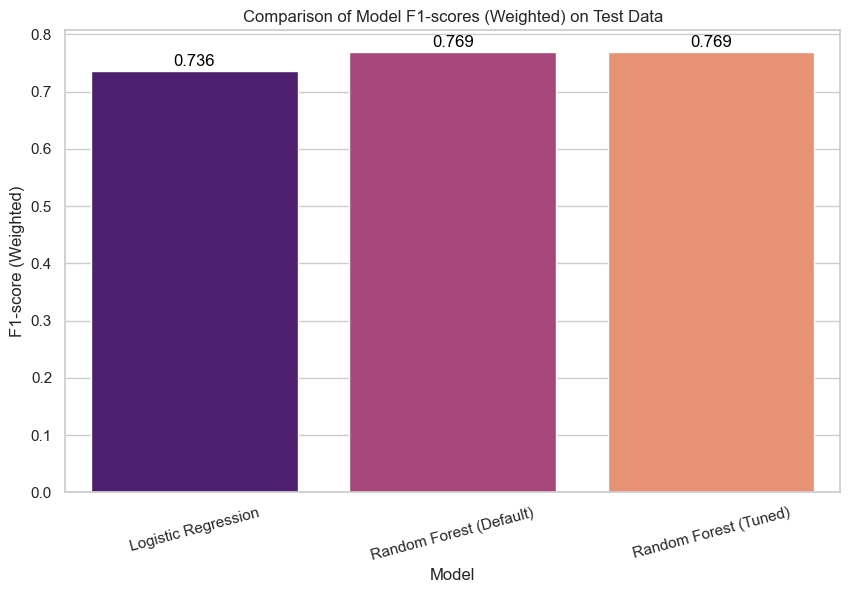


--- Detailed Explanation of Metrics ---

    - Akurasi (Accuracy): Proporsi total prediksi yang benar.
      Formula: (TP + TN) / (TP + TN + FP + FN).
      Cara kerja: Memberikan gambaran umum seberapa sering model benar. Bisa menyesatkan jika kelas tidak seimbang.

    - Presisi (Precision): Dari semua yang diprediksi sebagai kelas positif, berapa banyak yang benar-benar positif.
      Formula untuk kelas positif: TP / (TP + FP).
      Cara kerja: Presisi tinggi berarti model jarang salah mengklasifikasikan sampel negatif sebagai positif (rendah False Positive).
      (Weighted average memperhitungkan presisi untuk setiap kelas dan mengambil rata-ratanya berdasarkan jumlah sampel per kelas).

    - Recall (Sensitivity): Dari semua yang sebenarnya kelas positif, berapa banyak yang berhasil diprediksi sebagai positif.
      Formula untuk kelas positif: TP / (TP + FN).
      Cara kerja: Recall tinggi berarti model mampu menemukan sebagian besar sampel positif (rendah False Negative).
 

In [8]:
# ============== Evaluation - Summary of Results ==============

if 'log_reg_accuracy' in locals() and 'rf_default_accuracy' in locals() and 'rf_tuned_accuracy' in locals():
    results_summary = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest (Default)', 'Random Forest (Tuned)'],
        'Accuracy': [log_reg_accuracy, rf_default_accuracy, rf_tuned_accuracy],
        'Precision (Weighted)': [log_reg_precision, rf_default_precision, rf_tuned_precision],
        'Recall (Weighted)': [log_reg_recall, rf_default_recall, rf_tuned_recall],
        'F1-score (Weighted)': [log_reg_f1, rf_default_f1, rf_tuned_f1]
    })

    results_summary = results_summary.set_index('Model')
    print("--- Summary of Model Performance on Test Data ---")
    print(results_summary)

    # Plotting F1-scores for comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_summary.index, y='F1-score (Weighted)', data=results_summary.reset_index(), palette='magma')
    plt.title('Comparison of Model F1-scores (Weighted) on Test Data')
    plt.ylabel('F1-score (Weighted)')
    plt.xticks(rotation=15)
    for index, row in results_summary.reset_index().iterrows():
        plt.text(row.name, row['F1-score (Weighted)'] + 0.01, f"{row['F1-score (Weighted)']:.3f}", color='black', ha="center")
    plt.show()
    
    print("\n=======================================================")
    print("--- Detailed Explanation of Metrics ---")
    print("=======================================================")
    print("""
    - Akurasi (Accuracy): Proporsi total prediksi yang benar.
      Formula: (TP + TN) / (TP + TN + FP + FN).
      Cara kerja: Memberikan gambaran umum seberapa sering model benar. Bisa menyesatkan jika kelas tidak seimbang.

    - Presisi (Precision): Dari semua yang diprediksi sebagai kelas positif, berapa banyak yang benar-benar positif.
      Formula untuk kelas positif: TP / (TP + FP).
      Cara kerja: Presisi tinggi berarti model jarang salah mengklasifikasikan sampel negatif sebagai positif (rendah False Positive).
      (Weighted average memperhitungkan presisi untuk setiap kelas dan mengambil rata-ratanya berdasarkan jumlah sampel per kelas).

    - Recall (Sensitivity): Dari semua yang sebenarnya kelas positif, berapa banyak yang berhasil diprediksi sebagai positif.
      Formula untuk kelas positif: TP / (TP + FN).
      Cara kerja: Recall tinggi berarti model mampu menemukan sebagian besar sampel positif (rendah False Negative).
      (Weighted average memperhitungkan recall untuk setiap kelas).

    - F1-score: Rata-rata harmonik dari Presisi dan Recall.
      Formula: 2 * (Precision * Recall) / (Precision + Recall).
      Cara kerja: Memberikan keseimbangan antara presisi dan recall, berguna terutama jika ada ketidakseimbangan kelas atau jika kedua metrik (presisi dan recall) sama pentingnya.
      (Weighted average memperhitungkan F1-score untuk setiap kelas).

    - Confusion Matrix: Tabel yang menggambarkan performa model klasifikasi. Baris merepresentasikan kelas aktual, kolom merepresentasikan kelas prediksi.
      - TP (True Positive): Sampel positif yang diprediksi benar.
      - TN (True Negative): Sampel negatif yang diprediksi benar.
      - FP (False Positive): Sampel negatif yang salah diprediksi sebagai positif (Type I Error).      - FN (False Negative): Sampel positif yang salah diprediksi sebagai negatif (Type II Error).

    """)
else:
    print("Model evaluation summary not generated as no models were evaluated or data was not available.")